In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageDraw
import json
import pickle
from pathlib import Path
from typing import Dict, List, Tuple, Optional
import warnings

warnings.filterwarnings('ignore')

# TensorFlow/Keras imports (optimized for Apple Silicon)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Enable Metal Performance Shaders for Apple Silicon
if tf.config.list_physical_devices('GPU'):
    print("GPU Available - Apple Silicon Metal Performance Shaders")
else:
    print("Running on CPU")

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

GPU Available - Apple Silicon Metal Performance Shaders
TensorFlow version: 2.16.2
Keras version: 3.8.0


In [2]:
class CropWeedDataset:
    """
    Comprehensive dataset class for CropAndWeed dataset
    Enhanced with optimizations and advanced features
    """

    def __init__(self, dataset_path: str):
        self.dataset_path = Path(dataset_path)
        self.images_path = self.dataset_path / "images"
        self.annotations_path = self.dataset_path / "annotations"
        self.bboxes_path = self.annotations_path / "bboxes"
        self.labelids_path = self.annotations_path / "labelIds" / "CropAndWeed"
        self.params_path = self.annotations_path / "params"

        # Dataset containers
        self.image_info = {}
        self.bbox_annotations = {}
        self.mask_annotations = {}
        self.params_data = {}
        self.dataset_stats = {}

        # CropAndWeed Dataset Official Label Mappings
        self.cropweed_labels = {
            0: ('Soil', (0, 0, 0)),
            1: ('Maize', (255, 0, 0)),
            2: ('Maize two-leaf stage', (234, 0, 0)),
            3: ('Maize four-leaf stage', (212, 0, 0)),
            4: ('Maize six-leaf stage', (191, 0, 0)),
            5: ('Maize eight-leaf stage', (170, 0, 0)),
            6: ('Maize max', (149, 0, 0)),
            7: ('Sugar beet', (255, 85, 0)),
            8: ('Sugar beet two-leaf stage', (234, 78, 0)),
            9: ('Sugar beet four-leaf stage', (212, 71, 0)),
            10: ('Sugar beet six-leaf stage', (191, 64, 0)),
            11: ('Sugar beet eight-leaf stage', (170, 57, 0)),
            12: ('Sugar beet Max', (149, 50, 0)),
            13: ('Pea', (255, 170, 0)),
            14: ('Courgette', (255, 255, 0)),
            15: ('Pumpkins', (170, 255, 0)),
            16: ('Radish', (85, 255, 0)),
            17: ('Asparagus', (0, 255, 0)),
            18: ('Potato', (0, 255, 85)),
            19: ('Flat leaf parsley', (0, 255, 170)),
            20: ('Curly leaf parsley', (0, 255, 255)),
            21: ('Cowslip', (0, 170, 255)),
            22: ('Poppy', (0, 85, 255)),
            23: ('Hemp', (0, 0, 255)),
            24: ('Sunflower', (85, 0, 255)),
            25: ('Sage', (170, 0, 255)),
            26: ('Common bean', (255, 0, 255)),
            27: ('Faba bean', (255, 0, 170)),
            28: ('Clover', (255, 0, 85)),
            29: ('Hybrid goosefoot', (255, 188, 178)),
            30: ('Black-bindweed', (255, 207, 178)),
            31: ('Cockspur grass', (255, 226, 178)),
            32: ('Red-root amaranth', (255, 245, 178)),
            33: ('White goosefoot', (245, 255, 178)),
            34: ('Thorn apple', (226, 255, 178)),
            35: ('Potato weed', (207, 255, 178)),
            36: ('German chamomile', (188, 255, 178)),
            37: ('Saltbush', (178, 255, 188)),
            38: ('Creeping thistle', (178, 255, 207)),
            39: ('Field milk thistle', (178, 255, 226)),
            40: ('Purslane', (178, 255, 245)),
            41: ('Black nightshade', (178, 245, 255)),
            42: ('Mercuries', (178, 226, 255)),
            43: ('Spurge', (178, 207, 255)),
            44: ('Pale persicaria', (178, 188, 255)),
            45: ('Geraniums', (188, 178, 255)),
            46: ('Cleavers', (207, 178, 255)),
            47: ('Whitetop', (226, 178, 255)),
            48: ('Meadow-grass', (245, 178, 255)),
            49: ('Frosted orach', (255, 178, 245)),
            50: ('Black horehound', (255, 178, 226)),
            51: ('Shepherds purse', (255, 178, 207)),
            52: ('Field bindweed', (255, 178, 188)),
            53: ('Common mugwort', (255, 194, 178)),
            54: ('Hedge mustard', (255, 213, 178)),
            55: ('Groundsel', (255, 219, 178)),
            56: ('Speedwell', (255, 232, 178)),
            57: ('Broadleaf plantain', (255, 238, 178)),
            58: ('White ball-mustard', (255, 251, 178)),
            59: ('Peppermint', (255, 212, 0)),
            60: ('Field pennycress', (239, 255, 178)),
            61: ('Corn spurry', (233, 255, 178)),
            62: ('Purple crabgrass', (220, 255, 178)),
            63: ('Common fumitory', (214, 255, 178)),
            64: ('Ivy-leaved speedwell', (201, 255, 178)),
            65: ('Annual meadow grass', (195, 255, 178)),
            66: ('Redshank', (182, 255, 178)),
            67: ('Common hemp-nettle', (178, 255, 194)),
            68: ('Rough meadow-grass', (178, 255, 200)),
            69: ('Green bristlegrass', (178, 255, 213)),
            70: ('Small geranium', (178, 255, 220)),
            71: ('Cornflower', (178, 255, 232)),
            72: ('Common corn-cockle', (178, 255, 238)),
            73: ('Creeping crowfoot', (178, 255, 251)),
            74: ('Wall barley', (178, 239, 255)),
            75: ('Annual fescue', (178, 233, 255)),
            76: ('Purple dead-nettle', (178, 220, 255)),
            77: ('Ribwort plantain', (178, 214, 255)),
            78: ('Pineappleweed', (178, 201, 255)),
            79: ('Common chickweed', (178, 195, 255)),
            80: ('Hedge mustard', (178, 182, 255)),
            81: ('Soft brome', (194, 178, 255)),
            82: ('Wild pansy', (200, 178, 255)),
            83: ('Yellow rocket', (213, 178, 255)),
            84: ('Common wild oat', (219, 178, 255)),
            85: ('Red poppy', (232, 178, 255)),
            86: ('Rye brome', (238, 178, 255)),
            87: ('Knotgrass', (251, 178, 255)),
            88: ('Prickly lettuce', (255, 178, 239)),
            89: ('Copse-bindweed', (255, 178, 233)),
            90: ('Manyseeds', (255, 178, 220)),
            91: ('Common buckwheat', (255, 178, 214)),
            92: ('Chives', (212, 255, 0)),
            93: ('Garlic', (127, 255, 0)),
            94: ('Soybean', (42, 255, 0)),
            95: ('Wild carrot', (244, 255, 0)),
            96: ('Field mustard', (159, 255, 0)),
            97: ('Giant fennel', (74, 255, 0)),
            98: ('Common horsetail', (10, 255, 0)),
            99: ('Common dandelion', (202, 255, 0)),
            255: ('Vegetation', (128, 128, 128))
        }

        # Hierarchical dataset definitions for different granularities
        self.dataset_hierarchies = {
            'CropOrWeed2': {
                0: ('Crop', [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 94, 24, 18, 13, 26, 27, 15]),
                1: ('Weed',
                    [31, 48, 62, 65, 68, 69, 74, 75, 81, 84, 86, 32, 29, 33, 37, 49, 30, 44, 66, 87, 89, 91, 61, 79, 34,
                     41, 52, 35, 36, 78, 38, 39, 71, 72, 88, 42, 45, 70, 47, 51, 54, 58, 60, 80, 83, 96, 22, 63, 85, 56,
                     57, 64, 77, 50, 59, 67, 76])
            },
            'CropsOrWeed9': {
                0: ('Maize', [1, 2, 3, 4, 5, 6]),
                1: ('Sugar beet', [7, 8, 9, 10, 11, 12]),
                2: ('Soy', [94]),
                3: ('Sunflower', [24]),
                4: ('Potato', [18]),
                5: ('Pea', [13]),
                6: ('Bean', [26, 27]),
                7: ('Pumpkin', [15]),
                8: ('Weed',
                    [31, 48, 62, 65, 68, 69, 74, 75, 81, 84, 86, 32, 29, 33, 37, 49, 30, 44, 66, 87, 89, 91, 61, 79, 34,
                     41, 52, 35, 36, 78, 38, 39, 71, 72, 88, 42, 45, 70, 47, 51, 54, 58, 60, 80, 83, 96, 22, 63, 85, 56,
                     57, 64, 77, 50, 59, 67, 76])
            },
            'Fine24': {
                0: ('Maize', [1, 2, 3, 4, 5, 6]),
                1: ('Sugar beet', [7, 8, 9, 10, 11, 12]),
                2: ('Soy', [94]),
                3: ('Sunflower', [24]),
                4: ('Potato', [18]),
                5: ('Pea', [13]),
                6: ('Bean', [26, 27]),
                7: ('Pumpkin', [15]),
                8: ('Grasses', [31, 48, 62, 65, 68, 69, 74, 75, 81, 84, 86]),
                9: ('Amaranth', [32]),
                10: ('Goosefoot', [29, 33, 37, 49]),
                11: ('Knotweed', [30, 44, 66, 87, 89, 91]),
                12: ('Corn spurry', [61]),
                13: ('Chickweed', [79]),
                14: ('Solanales', [34, 41, 52]),
                15: ('Potato weed', [35]),
                16: ('Chamomile', [36, 78]),
                17: ('Thistle', [38, 39, 71, 72, 88]),
                18: ('Mercuries', [42]),
                19: ('Geranium', [45, 70]),
                20: ('Crucifer', [47, 51, 54, 58, 60, 80, 83, 96]),
                21: ('Poppy', [22, 63, 85]),
                22: ('Plantago', [56, 57, 64, 77]),
                23: ('Labiate', [50, 59, 67, 76])
            }
        }

        # Initialize with fine-grained labels by default
        self.label_mapping = {k: v[0] for k, v in self.cropweed_labels.items()}
        self.label_colors = {k: v[1] for k, v in self.cropweed_labels.items()}

        # Current hierarchy setting
        self.current_hierarchy = 'CropAndWeed'  # Original fine-grained

        self.param_mappings = {
            'moisture': {0: 'dry', 1: 'medium', 2: 'wet'},
            'soil': {0: 'fine', 1: 'medium', 2: 'coarse'},
            'lighting': {0: 'sunny', 1: 'diffuse'},
            'separability': {0: 'easy', 1: 'medium', 2: 'hard'}
        }

        print(f"Initialized CropWeedDataset from: {dataset_path}")
        self._validate_structure()

    def _validate_structure(self):
        """Validate dataset structure"""
        required_paths = [
            self.images_path,
            self.bboxes_path,
            self.labelids_path,
            self.params_path
        ]

        for path in required_paths:
            if not path.exists():
                raise FileNotFoundError(f"Required path not found: {path}")

        print("✓ Dataset structure validated")

    def load_dataset(self):
        """Load all dataset components"""
        print("Loading dataset components...")

        # Get all image files
        image_files = list(self.images_path.glob("*.jpg"))
        print(f"Found {len(image_files)} images")

        for img_file in image_files:
            img_id = img_file.stem
            self.image_info[img_id] = {
                'path': str(img_file),
                'filename': img_file.name
            }

            # Load image dimensions
            with Image.open(img_file) as img:
                self.image_info[img_id]['width'] = img.width
                self.image_info[img_id]['height'] = img.height

        # Load bounding box annotations
        self._load_bbox_annotations()

        # Load mask annotations
        self._load_mask_annotations()

        # Load parameters (FIXED VERSION)
        self._load_params()

        print("✓ Dataset loaded successfully")
        return self

    def _load_bbox_annotations(self):
        """Load bounding box annotations from CSV files"""
        bbox_files = list(self.bboxes_path.glob("*.csv"))

        for bbox_file in bbox_files:
            img_id = bbox_file.stem
            try:
                df = pd.read_csv(bbox_file, header=None,
                                 names=['left', 'top', 'right', 'bottom',
                                        'label_id', 'stem_x', 'stem_y'])
                self.bbox_annotations[img_id] = df
            except Exception as e:
                print(f"Error loading {bbox_file}: {e}")

        print(f"✓ Loaded bounding boxes for {len(self.bbox_annotations)} images")

    def _load_mask_annotations(self):
        """Load semantic mask annotations"""
        mask_files = list(self.labelids_path.glob("*.png"))

        for mask_file in mask_files:
            img_id = mask_file.stem
            self.mask_annotations[img_id] = str(mask_file)

        print(f"✓ Loaded masks for {len(self.mask_annotations)} images")

    def _load_params(self):
        """Load parameter files - FIXED VERSION"""
        param_files = list(self.params_path.glob("*.csv"))

        for param_file in param_files:
            img_id = param_file.stem
            try:
                # Read the first row as parameter values
                df = pd.read_csv(param_file, header=None)

                # Map to parameter names in order
                param_names = ['moisture', 'soil', 'lighting', 'separability']
                params_dict = {}

                if len(df) > 0:
                    first_row = df.iloc[0]
                    for idx, param_name in enumerate(param_names):
                        if idx < len(first_row):
                            # Convert to proper data type
                            value = first_row.iloc[idx]
                            if isinstance(value, str) and value.isdigit():
                                params_dict[param_name] = int(value)
                            elif isinstance(value, (int, float)):
                                params_dict[param_name] = int(value)
                            else:
                                # Try to extract numeric value
                                try:
                                    params_dict[param_name] = int(float(str(value)))
                                except:
                                    params_dict[param_name] = 0

                self.params_data[img_id] = params_dict

            except Exception as e:
                print(f"Error loading {param_file}: {e}")
                # Default fallback
                self.params_data[img_id] = {
                    'moisture': 0, 'soil': 0, 'lighting': 0, 'separability': 0
                }

        print(f"✓ Loaded parameters for {len(self.params_data)} images")

    def set_label_hierarchy(self, hierarchy_name: str = 'CropAndWeed'):
        """
        Set the label hierarchy for training
        Options: 'CropAndWeed' (100 classes), 'CropOrWeed2' (2 classes),
                'CropsOrWeed9' (9 classes), 'Fine24' (24 classes)
        """
        if hierarchy_name == 'CropAndWeed':
            # Use original fine-grained labels
            self.label_mapping = {k: v[0] for k, v in self.cropweed_labels.items()}
            self.current_hierarchy = hierarchy_name
            print(f"✓ Using fine-grained CropAndWeed labels ({len(self.label_mapping)} classes)")
        elif hierarchy_name in self.dataset_hierarchies:
            # Use hierarchical mapping
            hierarchy = self.dataset_hierarchies[hierarchy_name]
            self.label_mapping = {k: v[0] for k, v in hierarchy.items()}
            self.current_hierarchy = hierarchy_name
            print(f"✓ Using {hierarchy_name} hierarchy ({len(hierarchy)} classes)")
        else:
            available = list(self.dataset_hierarchies.keys()) + ['CropAndWeed']
            raise ValueError(f"Unknown hierarchy '{hierarchy_name}'. Available: {available}")

        return self.label_mapping

    def convert_labels_to_hierarchy(self, original_labels: np.ndarray) -> np.ndarray:
        """Convert original fine-grained labels to current hierarchy"""
        if self.current_hierarchy == 'CropAndWeed':
            return original_labels

        hierarchy = self.dataset_hierarchies[self.current_hierarchy]
        converted = np.zeros_like(original_labels)

        for new_id, (name, original_ids) in hierarchy.items():
            mask = np.isin(original_labels, original_ids)
            converted[mask] = new_id

        return converted

    def get_label_color(self, label_id: int, hierarchy: str = None) -> Tuple[int, int, int]:
        """Get RGB color for a label"""
        if hierarchy is None:
            hierarchy = self.current_hierarchy

        if hierarchy == 'CropAndWeed' and label_id in self.label_colors:
            return self.label_colors[label_id]
        elif hierarchy in self.dataset_hierarchies:
            # Use predefined colors for hierarchical labels
            colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0),
                      (255, 0, 255), (0, 255, 255), (128, 128, 0), (128, 0, 128),
                      (0, 128, 128), (192, 192, 192)]
            return colors[label_id % len(colors)]
        else:
            return (128, 128, 128)  # Default gray

    def analyze_dataset_statistics(self):
        """Comprehensive dataset analysis"""
        print("Analyzing dataset statistics...")

        stats = {
            'total_images': len(self.image_info),
            'images_with_bboxes': len(self.bbox_annotations),
            'images_with_masks': len(self.mask_annotations),
            'images_with_params': len(self.params_data)
        }

        # Image size analysis
        widths = [info['width'] for info in self.image_info.values()]
        heights = [info['height'] for info in self.image_info.values()]

        stats['image_sizes'] = {
            'width_range': (min(widths), max(widths)),
            'height_range': (min(heights), max(heights)),
            'avg_width': np.mean(widths),
            'avg_height': np.mean(heights)
        }

        # Bounding box analysis
        all_labels = []
        bbox_counts = []
        stem_points = []

        for img_id, df in self.bbox_annotations.items():
            all_labels.extend(df['label_id'].tolist())
            bbox_counts.append(len(df))
            stem_points.extend([(x, y) for x, y in zip(df['stem_x'], df['stem_y'])
                                if not (pd.isna(x) or pd.isna(y))])

        stats['bboxes'] = {
            'total_objects': len(all_labels),
            'label_distribution': pd.Series(all_labels).value_counts().to_dict(),
            'avg_objects_per_image': np.mean(bbox_counts),
            'objects_per_image_range': (min(bbox_counts), max(bbox_counts)),
            'stem_points_available': len(stem_points)
        }

        # Parameter analysis
        param_analysis = {}
        for param_name in ['moisture', 'soil', 'lighting', 'separability']:
            values = []
            for params in self.params_data.values():
                if param_name in params:
                    values.append(params[param_name])

            if values:
                param_analysis[param_name] = {
                    'distribution': pd.Series(values).value_counts().to_dict(),
                    'total_samples': len(values)
                }

        stats['parameters'] = param_analysis

        self.dataset_stats = stats
        return stats

    def create_train_val_split(self, val_split: float = 0.2, test_split: float = 0.1,
                               stratify_by: str = None, random_state: int = 42):
        """Create train/validation/test splits with optional stratification"""

        # Get common image IDs (images that have all annotations)
        common_ids = set(self.image_info.keys())
        if self.bbox_annotations:
            common_ids &= set(self.bbox_annotations.keys())
        if self.mask_annotations:
            common_ids &= set(self.mask_annotations.keys())
        if self.params_data:
            common_ids &= set(self.params_data.keys())

        common_ids = list(common_ids)
        print(f"Found {len(common_ids)} images with complete annotations")

        # Debug: Check parameter structure
        if len(common_ids) > 0 and self.params_data:
            sample_params = self.params_data[common_ids[0]]
            print(f"Sample parameter keys: {list(sample_params.keys())}")
            print(f"Sample parameter values: {sample_params}")

        # Attempt stratification if requested and possible
        stratify_values = None
        if stratify_by and self.params_data and len(common_ids) > 0:
            try:
                stratify_values = []
                valid_ids = []

                for img_id in common_ids:
                    if img_id in self.params_data and stratify_by in self.params_data[img_id]:
                        # Ensure we have numeric values for stratification
                        param_value = self.params_data[img_id][stratify_by]
                        if isinstance(param_value, (int, float)):
                            stratify_values.append(param_value)
                            valid_ids.append(img_id)

                if len(valid_ids) > 0 and len(set(stratify_values)) > 1:
                    common_ids = valid_ids
                    print(f"Using stratification by '{stratify_by}' with {len(valid_ids)} valid samples")
                    print(f"Stratification value distribution: {pd.Series(stratify_values).value_counts().to_dict()}")
                else:
                    print(f"Cannot stratify by '{stratify_by}' - insufficient valid samples or variance")
                    stratify_values = None
            except Exception as e:
                print(f"Stratification failed: {e}. Using random split.")
                stratify_values = None

        if len(common_ids) == 0:
            raise ValueError("No images found with complete annotations!")

        # Perform splits
        try:
            if stratify_values is not None and len(set(stratify_values)) > 1:
                # First split: train+val vs test
                train_val_ids, test_ids = train_test_split(
                    common_ids, test_size=test_split,
                    stratify=stratify_values, random_state=random_state
                )

                # Second split: train vs val
                train_stratify = [self.params_data[img_id][stratify_by] for img_id in train_val_ids]
                train_ids, val_ids = train_test_split(
                    train_val_ids, test_size=val_split / (1 - test_split),
                    stratify=train_stratify, random_state=random_state
                )
            else:
                # Random split without stratification
                train_val_ids, test_ids = train_test_split(
                    common_ids, test_size=test_split, random_state=random_state
                )
                train_ids, val_ids = train_test_split(
                    train_val_ids, test_size=val_split / (1 - test_split),
                    random_state=random_state
                )
        except Exception as e:
            print(f"Error during splitting: {e}")
            # Fallback to simple random split
            train_val_ids, test_ids = train_test_split(
                common_ids, test_size=test_split, random_state=random_state
            )
            train_ids, val_ids = train_test_split(
                train_val_ids, test_size=val_split / (1 - test_split),
                random_state=random_state
            )

        splits = {
            'train': train_ids,
            'val': val_ids,
            'test': test_ids
        }

        print(f"Dataset splits:")
        print(f"  Train: {len(train_ids)} images")
        print(f"  Validation: {len(val_ids)} images")
        print(f"  Test: {len(test_ids)} images")

        return splits

    def plot_class_distribution(self, hierarchy='CropOrWeed2', figsize=(15, 6)):
        """Enhanced visualization of class distributions"""
        original_hierarchy = self.current_hierarchy
        self.set_label_hierarchy(hierarchy)
        stats = self.analyze_dataset_statistics()

        # Create beautiful plots
        fig, axes = plt.subplots(1, 2, figsize=figsize)

        # Class distribution
        label_dist = stats['bboxes']['label_distribution']
        
        # Convert label IDs to class names for current hierarchy
        if hierarchy != 'CropAndWeed':
            # Map original labels to hierarchy labels
            hierarchy_dist = {}
            hierarchy_data = self.dataset_hierarchies[hierarchy]
            
            for new_label, (name, original_labels) in hierarchy_data.items():
                count = sum(label_dist.get(orig_label, 0) for orig_label in original_labels)
                if count > 0:
                    hierarchy_dist[name] = count
            
            class_names = list(hierarchy_dist.keys())
            class_counts = list(hierarchy_dist.values())
        else:
            # Use top 10 classes for full hierarchy
            sorted_labels = sorted(label_dist.items(), key=lambda x: x[1], reverse=True)[:10]
            class_names = [self.cropweed_labels.get(k, f'Class_{k}')[0] for k, v in sorted_labels]
            class_counts = [v for k, v in sorted_labels]

        # Create bar chart
        bars = axes[0].bar(range(len(class_counts)), class_counts)
        axes[0].set_xticks(range(len(class_names)))
        axes[0].set_xticklabels(class_names, rotation=45, ha='right')
        axes[0].set_title(f'{hierarchy} - Object Distribution')
        axes[0].set_ylabel('Object Count')

# Color bars differently for crops vs weeds in binary classification
        if hierarchy == 'CropOrWeed2':
            bars[0].set_color('green')  # Crop
            bars[1].set_color('red')    # Weed

        # Environmental parameters pie chart
        if 'parameters' in stats and stats['parameters']:
            # Try to plot moisture distribution
            param_to_plot = None
            for param_name in ['moisture', 'soil', 'lighting', 'separability']:
                if param_name in stats['parameters']:
                    param_to_plot = param_name
                    break
            
            if param_to_plot:
                param_dist = stats['parameters'][param_to_plot]['distribution']
                param_labels = [self.param_mappings[param_to_plot].get(k, f'{param_to_plot}_{k}') 
                               for k in param_dist.keys()]
                
                axes[1].pie(param_dist.values(), labels=param_labels, autopct='%1.1f%%')
                axes[1].set_title(f'{param_to_plot.capitalize()} Distribution')
            else:
                axes[1].text(0.5, 0.5, 'No parameter data available', 
                           ha='center', va='center', transform=axes[1].transAxes)
                axes[1].set_title('Environmental Parameters')
        else:
            axes[1].text(0.5, 0.5, 'No parameter data available', 
                       ha='center', va='center', transform=axes[1].transAxes)
            axes[1].set_title('Environmental Parameters')

        plt.tight_layout()
        plt.show()

        # Restore original hierarchy
        self.set_label_hierarchy(original_hierarchy)

    def visualize_dataset(self, num_samples: int = 6, figsize: Tuple[int, int] = (15, 10),
                          hierarchy: str = None):
        """Visualize dataset samples with annotations"""

        if hierarchy:
            original_hierarchy = self.current_hierarchy
            self.set_label_hierarchy(hierarchy)

        # Select random samples
        sample_ids = np.random.choice(list(self.image_info.keys()),
                                      min(num_samples, len(self.image_info)),
                                      replace=False)

        fig, axes = plt.subplots(2, 3, figsize=figsize)
        axes = axes.flatten()

        for idx, img_id in enumerate(sample_ids):
            if idx >= len(axes):
                break

            # Load and display image
            img_path = self.image_info[img_id]['path']
            img = Image.open(img_path)

            # Draw bounding boxes if available
            if img_id in self.bbox_annotations:
                draw = ImageDraw.Draw(img)
                df = self.bbox_annotations[img_id]

                # Count objects by type
                label_counts = {}

                for _, row in df.iterrows():
                    left, top, right, bottom = row['left'], row['top'], row['right'], row['bottom']
                    original_label_id = int(row['label_id'])

                    # Convert to current hierarchy if needed
                    if self.current_hierarchy != 'CropAndWeed':
                        converted_labels = self.convert_labels_to_hierarchy(np.array([original_label_id]))
                        display_label_id = converted_labels[0]
                    else:
                        display_label_id = original_label_id

                    # Get color and label name
                    color = self.get_label_color(display_label_id)
                    label_name = self.label_mapping.get(display_label_id, f'Unknown_{display_label_id}')

                    # Count for legend
                    if label_name not in label_counts:
                        label_counts[label_name] = 0
                    label_counts[label_name] += 1

                    # Draw bounding box
                    draw.rectangle([left, top, right, bottom], outline=color, width=2)

                    # Draw stem point if available
                    if not (pd.isna(row['stem_x']) or pd.isna(row['stem_y'])):
                        stem_x, stem_y = int(row['stem_x']), int(row['stem_y'])
                        draw.ellipse([stem_x - 3, stem_y - 3, stem_x + 3, stem_y + 3],
                                     fill=color, outline='white')

                # Create title with object counts
                title_parts = [img_id]
                if label_counts:
                    count_str = ", ".join([f"{name}: {count}" for name, count in label_counts.items()])
                    title_parts.append(count_str)
                title = "\n".join(title_parts)
            else:
                title = f"{img_id}\nNo annotations"

            axes[idx].imshow(img)
            axes[idx].set_title(title, fontsize=8)
            axes[idx].axis('off')

        # Hide unused subplots
        for idx in range(len(sample_ids), len(axes)):
            axes[idx].axis('off')

        plt.suptitle(f'Dataset Samples ({self.current_hierarchy} hierarchy)', fontsize=14)
        plt.tight_layout()
        plt.show()

        # Restore original hierarchy if changed
        if hierarchy and hierarchy != original_hierarchy:
            self.set_label_hierarchy(original_hierarchy)

    def create_training_callbacks(self, model_name='crop_weed_model', save_dir='models'):
        """Create standard training callbacks"""
        
        # Create models directory if it doesn't exist
        Path(save_dir).mkdir(exist_ok=True)
        
        callbacks = [
            tf.keras.callbacks.ModelCheckpoint(
                f'{save_dir}/{model_name}_best.h5',
                monitor='val_accuracy',
                save_best_only=True,
                verbose=1,
                save_weights_only=False
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.2,
                patience=5,
                min_lr=1e-7,
                verbose=1
            ),
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=10,
                verbose=1,
                restore_best_weights=True
            ),
            tf.keras.callbacks.CSVLogger(
                f'{save_dir}/{model_name}_training_log.csv',
                append=True
            )
        ]
        return callbacks

    def experiment_with_hierarchies(self):
        """Experiment with different classification tasks"""
        print("=== Hierarchy Experiments ===")

        experiments = {
            'CropOrWeed2': 'Binary Classification (Crop vs Weed)',
            'CropsOrWeed9': 'Multi-class (8 crops + weeds)',
            'Fine24': 'Botanical families (24 classes)',
            'CropAndWeed': 'Species-level (100+ classes)'
        }

        results = {}
        original_hierarchy = self.current_hierarchy

        for hierarchy, description in experiments.items():
            print(f"\n{hierarchy}: {description}")

            if hierarchy == 'CropAndWeed':
                self.set_label_hierarchy('CropAndWeed')
            else:
                self.set_label_hierarchy(hierarchy)

            # Analyze class distribution
            stats = self.analyze_dataset_statistics()
            label_dist = stats['bboxes']['label_distribution']

            results[hierarchy] = {
                'num_classes': len(self.label_mapping),
                'total_objects': sum(label_dist.values()),
                'class_names': list(self.label_mapping.values())[:5],  # First 5
                'most_common': sorted(label_dist.items(), key=lambda x: x[1], reverse=True)[:3]
            }

            print(f"  Classes: {results[hierarchy]['num_classes']}")
            print(f"  Objects: {results[hierarchy]['total_objects']}")
            print(f"  Top classes: {results[hierarchy]['most_common']}")

        # Restore original hierarchy
        self.set_label_hierarchy(original_hierarchy)
        return results

In [3]:
class CropWeedDetectionGenerator(Sequence):
    """
    Enhanced Keras data generator for object detection tasks
    Supports different label hierarchies and data augmentation
    """

    def __init__(self, dataset: CropWeedDataset, image_ids: List[str],
                 batch_size: int = 8, image_size: Tuple[int, int] = (512, 512),
                 hierarchy: str = 'CropOrWeed2', augment: bool = False, shuffle: bool = True):

        self.dataset = dataset
        self.image_ids = image_ids
        self.batch_size = batch_size
        self.image_size = image_size
        self.hierarchy = hierarchy
        self.augment = augment
        self.shuffle = shuffle

        # Set dataset to use specified hierarchy
        self.dataset.set_label_hierarchy(hierarchy)
        self.num_classes = len(self.dataset.label_mapping)

        self.indices = np.arange(len(self.image_ids))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __len__(self):
        return int(np.ceil(len(self.image_ids) / self.batch_size))

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_ids = [self.image_ids[i] for i in batch_indices]

        return self._generate_batch(batch_ids)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

    def _apply_augmentation(self, img_array, boxes=None):
        """Apply data augmentation"""
        if not self.augment:
            return img_array, boxes

        # Random horizontal flip
        if np.random.random() > 0.5:
            img_array = tf.image.flip_left_right(img_array)
            if boxes is not None and len(boxes) > 0:
                # Flip bounding boxes
                boxes = np.array(boxes)
                boxes[:, [1, 3]] = 1.0 - boxes[:, [3, 1]]  # Flip x coordinates

        # Random brightness
        img_array = tf.image.random_brightness(img_array, max_delta=0.2)

        # Random contrast
        img_array = tf.image.random_contrast(img_array, lower=0.8, upper=1.2)

        # Random saturation
        img_array = tf.image.random_saturation(img_array, lower=0.8, upper=1.2)

        return img_array, boxes

    def _generate_batch(self, batch_ids):
        batch_images = []
        batch_boxes = []
        batch_labels = []

        for img_id in batch_ids:
            # Load and preprocess image
            img_path = self.dataset.image_info[img_id]['path']
            img = tf.keras.utils.load_img(img_path, target_size=self.image_size)
            img_array = tf.keras.utils.img_to_array(img) / 255.0

            # Load bounding boxes
            boxes = []
            labels = []
            
            if img_id in self.dataset.bbox_annotations:
                df = self.dataset.bbox_annotations[img_id]

                # Normalize coordinates
                orig_width = self.dataset.image_info[img_id]['width']
                orig_height = self.dataset.image_info[img_id]['height']

                for _, row in df.iterrows():
                    # Convert original label to current hierarchy
                    original_label = int(row['label_id'])
                    if self.hierarchy != 'CropAndWeed':
                        converted_label = self.dataset.convert_labels_to_hierarchy(np.array([original_label]))[0]
                    else:
                        converted_label = original_label

                    # Skip if label not in current hierarchy
                    if converted_label not in self.dataset.label_mapping:
                        continue

                    # Normalize coordinates to [0, 1]
                    x1 = row['left'] / orig_width
                    y1 = row['top'] / orig_height
                    x2 = row['right'] / orig_width
                    y2 = row['bottom'] / orig_height

                    boxes.append([y1, x1, y2, x2])  # TensorFlow format: [y1, x1, y2, x2]
                    labels.append(converted_label)

            # Apply augmentation
            img_array, boxes = self._apply_augmentation(img_array, boxes)

            batch_images.append(img_array)
            batch_boxes.append(np.array(boxes) if boxes else np.array([]).reshape(0, 4))
            batch_labels.append(np.array(labels) if labels else np.array([]))

        return np.array(batch_images), {
            'boxes': batch_boxes,
            'labels': batch_labels
        }


In [4]:
class CropWeedSegmentationGenerator(Sequence):
    """
    Enhanced Keras data generator for semantic segmentation tasks
    """

    def __init__(self, dataset: CropWeedDataset, image_ids: List[str],
                 batch_size: int = 4, image_size: Tuple[int, int] = (512, 512),
                 hierarchy: str = 'CropOrWeed2', augment: bool = False, shuffle: bool = True):

        self.dataset = dataset
        self.image_ids = image_ids
        self.batch_size = batch_size
        self.image_size = image_size
        self.hierarchy = hierarchy
        self.augment = augment
        self.shuffle = shuffle

        # Set dataset to use specified hierarchy
        self.dataset.set_label_hierarchy(hierarchy)
        self.num_classes = len(self.dataset.label_mapping)

        # Filter to only include images with masks
        self.image_ids = [img_id for img_id in image_ids
                          if img_id in dataset.mask_annotations]

        self.indices = np.arange(len(self.image_ids))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __len__(self):
        return int(np.ceil(len(self.image_ids) / self.batch_size))

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_ids = [self.image_ids[i] for i in batch_indices]

        return self._generate_batch(batch_ids)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

    def _generate_batch(self, batch_ids):
        batch_images = []
        batch_masks = []

        for img_id in batch_ids:
            # Load and preprocess image
            img_path = self.dataset.image_info[img_id]['path']
            img = tf.keras.utils.load_img(img_path, target_size=self.image_size)
            img_array = tf.keras.utils.img_to_array(img) / 255.0

            # Load and preprocess mask
            mask_path = self.dataset.mask_annotations[img_id]
            mask = tf.keras.utils.load_img(mask_path, target_size=self.image_size,
                                           color_mode='grayscale')
            mask_array = tf.keras.utils.img_to_array(mask).squeeze().astype(np.uint8)

            # Convert mask to current hierarchy if needed
            if self.hierarchy != 'CropAndWeed':
                # Create a new mask with mapped labels
                converted_mask = np.zeros_like(mask_array)
                hierarchy_data = self.dataset.dataset_hierarchies[self.hierarchy]

                for new_label, (name, original_labels) in hierarchy_data.items():
                    for orig_label in original_labels:
                        converted_mask[mask_array == orig_label] = new_label

                # Handle unmapped pixels (keep as background)
                unmapped_mask = np.ones_like(mask_array, dtype=bool)
                for orig_labels in [labels for _, labels in hierarchy_data.values()]:
                    for orig_label in orig_labels:
                        unmapped_mask[mask_array == orig_label] = False

                # Set unmapped pixels to background (0)
                converted_mask[unmapped_mask] = 0
                mask_array = converted_mask

            # Ensure mask values are within valid range
            mask_array = np.clip(mask_array, 0, self.num_classes - 1)

            # Apply same augmentation to both image and mask
            if self.augment:
                if np.random.random() > 0.5:
                    img_array = tf.image.flip_left_right(img_array)
                    mask_array = tf.image.flip_left_right(mask_array[..., np.newaxis]).numpy().squeeze()

                # Only apply color augmentations to image
                img_array = tf.image.random_brightness(img_array, max_delta=0.2)
                img_array = tf.image.random_contrast(img_array, lower=0.8, upper=1.2)

            # Convert to categorical
            mask_categorical = tf.keras.utils.to_categorical(
                mask_array, num_classes=self.num_classes
            )

            batch_images.append(img_array)
            batch_masks.append(mask_categorical)

        return np.array(batch_images), np.array(batch_masks)


In [7]:
# Enhanced Model Architectures

def create_binary_classification_model(input_shape=(224, 224, 3), dropout_rate=0.3):
    """Create an enhanced binary crop/weed classifier"""
    
    # Use EfficientNetB0 as backbone for better performance
    base_model = tf.keras.applications.EfficientNetB0(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )
    
    # Freeze base model initially
    base_model.trainable = False
    
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(dropout_rate / 2),
        tf.keras.layers.Dense(2, activation='softmax', name='predictions')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )
    
    return model, base_model


def create_multiclass_classification_model(num_classes, input_shape=(224, 224, 3), dropout_rate=0.3):
    """Create multiclass classifier for different hierarchies"""
    
    base_model = tf.keras.applications.EfficientNetB0(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )
    
    base_model.trainable = False
    
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(dropout_rate / 2),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(dropout_rate / 3),
        tf.keras.layers.Dense(num_classes, activation='softmax', name='predictions')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='categorical_crossentropy',
        metrics=['accuracy', 'top_3_accuracy']
    )
    
    return model, base_model


def create_segmentation_model(num_classes=2, input_shape=(256, 256, 3)):
    """Create an enhanced U-Net style segmentation model"""
    inputs = tf.keras.layers.Input(shape=input_shape)

    # Encoder (downsampling path)
    conv1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    conv1 = tf.keras.layers.BatchNormalization()(conv1)
    pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    conv2 = tf.keras.layers.BatchNormalization()(conv2)
    pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    conv3 = tf.keras.layers.BatchNormalization()(conv3)
    pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)
    conv4 = tf.keras.layers.BatchNormalization()(conv4)
    drop4 = tf.keras.layers.Dropout(0.5)(conv4)
    pool4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(drop4)

    # Bottleneck
    conv5 = tf.keras.layers.Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = tf.keras.layers.Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    conv5 = tf.keras.layers.BatchNormalization()(conv5)
    drop5 = tf.keras.layers.Dropout(0.5)(conv5)

    # Decoder (upsampling path)
    up6 = tf.keras.layers.Conv2D(512, 2, activation='relu', padding='same')(
        tf.keras.layers.UpSampling2D(size=(2, 2))(drop5))
    merge6 = tf.keras.layers.concatenate([drop4, up6], axis=3)
    conv6 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(conv6)
    conv6 = tf.keras.layers.BatchNormalization()(conv6)

    up7 = tf.keras.layers.Conv2D(256, 2, activation='relu', padding='same')(
        tf.keras.layers.UpSampling2D(size=(2, 2))(conv6))
    merge7 = tf.keras.layers.concatenate([conv3, up7], axis=3)
    conv7 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(conv7)
    conv7 = tf.keras.layers.BatchNormalization()(conv7)

    up8 = tf.keras.layers.Conv2D(128, 2, activation='relu', padding='same')(
        tf.keras.layers.UpSampling2D(size=(2, 2))(conv7))
    merge8 = tf.keras.layers.concatenate([conv2, up8], axis=3)
    conv8 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(conv8)
    conv8 = tf.keras.layers.BatchNormalization()(conv8)

    up9 = tf.keras.layers.Conv2D(64, 2, activation='relu', padding='same')(
        tf.keras.layers.UpSampling2D(size=(2, 2))(conv8))
    merge9 = tf.keras.layers.concatenate([conv1, up9], axis=3)
    conv9 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(conv9)
    conv9 = tf.keras.layers.BatchNormalization()(conv9)

    # Output layer
    outputs = tf.keras.layers.Conv2D(num_classes, 1, activation='softmax')(conv9)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=num_classes)]
    )
    
    return model


# Training Pipeline Functions

def create_classification_data_generator(dataset, image_ids, hierarchy='CropOrWeed2', 
                                        batch_size=16, image_size=(224, 224), augment=False):
    """Create a data generator specifically for classification tasks"""
    
    class ClassificationGenerator(Sequence):
        def __init__(self, dataset, image_ids, hierarchy, batch_size, image_size, augment):
            self.dataset = dataset
            self.image_ids = image_ids
            self.hierarchy = hierarchy
            self.batch_size = batch_size
            self.image_size = image_size
            self.augment = augment
            
            # Set hierarchy
            self.dataset.set_label_hierarchy(hierarchy)
            self.num_classes = len(self.dataset.label_mapping)
            
            self.indices = np.arange(len(self.image_ids))
            np.random.shuffle(self.indices)
        
        def __len__(self):
            return int(np.ceil(len(self.image_ids) / self.batch_size))
        
        def __getitem__(self, idx):
            batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
            batch_ids = [self.image_ids[i] for i in batch_indices]
            
            batch_images = []
            batch_labels = []
            
            for img_id in batch_ids:
                # Load image
                img_path = self.dataset.image_info[img_id]['path']
                img = tf.keras.utils.load_img(img_path, target_size=self.image_size)
                img_array = tf.keras.utils.img_to_array(img) / 255.0
                
                # Apply augmentation
                if self.augment:
                    if np.random.random() > 0.5:
                        img_array = tf.image.flip_left_right(img_array)
                    img_array = tf.image.random_brightness(img_array, max_delta=0.2)
                    img_array = tf.image.random_contrast(img_array, lower=0.8, upper=1.2)
                
                # Determine label based on majority class in image
                if img_id in self.dataset.bbox_annotations:
                    df = self.dataset.bbox_annotations[img_id]
                    labels = []
                    
                    for _, row in df.iterrows():
                        original_label = int(row['label_id'])
                        if self.hierarchy != 'CropAndWeed':
                            converted_label = self.dataset.convert_labels_to_hierarchy(np.array([original_label]))[0]
                        else:
                            converted_label = original_label
                        
                        if converted_label in self.dataset.label_mapping:
                            labels.append(converted_label)
                    
                    if labels:
                        # Use most common label as image label
                        image_label = max(set(labels), key=labels.count)
                    else:
                        image_label = 0  # Default to first class
                else:
                    image_label = 0
                
                # Convert to categorical
                label_categorical = tf.keras.utils.to_categorical(image_label, num_classes=self.num_classes)
                
                batch_images.append(img_array)
                batch_labels.append(label_categorical)
            
            return np.array(batch_images), np.array(batch_labels)
        
        def on_epoch_end(self):
            np.random.shuffle(self.indices)
    
    return ClassificationGenerator(dataset, image_ids, hierarchy, batch_size, image_size, augment)


def train_classification_model(dataset, splits, hierarchy='CropOrWeed2', epochs=20, 
                              batch_size=16, image_size=(224, 224)):
    """Complete training pipeline for classification"""
    
    print(f"=== Training Classification Model ({hierarchy}) ===")
    
    # Set hierarchy
    dataset.set_label_hierarchy(hierarchy)
    num_classes = len(dataset.label_mapping)
    print(f"Number of classes: {num_classes}")
    print(f"Classes: {list(dataset.label_mapping.values())}")
    
    # Create data generators
    train_gen = create_classification_data_generator(
        dataset, splits['train'], hierarchy, batch_size, image_size, augment=True
    )
    val_gen = create_classification_data_generator(
        dataset, splits['val'], hierarchy, batch_size, image_size, augment=False
    )
    
    print(f"Training generator: {len(train_gen)} batches")
    print(f"Validation generator: {len(val_gen)} batches")
    
    # Create model
    if num_classes == 2:
        model, base_model = create_binary_classification_model((*image_size, 3))
    else:
        model, base_model = create_multiclass_classification_model(num_classes, (*image_size, 3))
    
    print(f"Model created with {model.count_params():,} parameters")
    
    # Create callbacks
    callbacks = dataset.create_training_callbacks(f'{hierarchy}_classifier')
    
    # Train model
    print("Starting training...")
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
    )
    
    print("Training completed!")
    return model, history


def create_agricultural_metrics():
    """Create agriculture-specific evaluation metrics"""
    
    def crop_precision(y_true, y_pred):
        """Calculate precision for crop class specifically"""
        # Assuming crop is class 0 in binary classification
        crop_true = tf.equal(tf.argmax(y_true, axis=1), 0)
        crop_pred = tf.equal(tf.argmax(y_pred, axis=1), 0)
        
        true_positives = tf.reduce_sum(tf.cast(tf.logical_and(crop_true, crop_pred), tf.float32))
        predicted_positives = tf.reduce_sum(tf.cast(crop_pred, tf.float32))
        
        return tf.where(tf.equal(predicted_positives, 0), 0.0, true_positives / predicted_positives)
    
    def weed_recall(y_true, y_pred):
        """Calculate recall for weed class - important for herbicide application"""
        # Assuming weed is class 1 in binary classification
        weed_true = tf.equal(tf.argmax(y_true, axis=1), 1)
        weed_pred = tf.equal(tf.argmax(y_pred, axis=1), 1)
        
        true_positives = tf.reduce_sum(tf.cast(tf.logical_and(weed_true, weed_pred), tf.float32))
        actual_positives = tf.reduce_sum(tf.cast(weed_true, tf.float32))
        
        return tf.where(tf.equal(actual_positives, 0), 0.0, true_positives / actual_positives)
    
    def field_coverage_score(y_true, y_pred):
        """Calculate how well the model covers the field"""
        # This is a simplified version - in practice you'd want to consider spatial distribution
        predicted_vegetation = tf.reduce_sum(tf.cast(tf.argmax(y_pred, axis=1) > 0, tf.float32))
        total_pixels = tf.cast(tf.shape(y_pred)[0], tf.float32)
        
        return predicted_vegetation / total_pixels
    
    return {
        'crop_precision': crop_precision,
        'weed_recall': weed_recall,
        'field_coverage': field_coverage_score
    }


def progressive_training_schedule(dataset, splits):
    """Create progressive training schedule"""
    
    schedule = [
        {
            'name': 'Phase 1: Binary Classification',
            'hierarchy': 'CropOrWeed2',
            'epochs': 15,
            'image_size': (224, 224),
            'batch_size': 32,
            'learning_rate': 1e-3,
            'description': 'Learn basic crop vs weed distinction'
        },
        {
            'name': 'Phase 2: Multi-crop Detection', 
            'hierarchy': 'CropsOrWeed9',
            'epochs': 25,
            'image_size': (256, 256),
            'batch_size': 16,
            'learning_rate': 1e-4,
            'description': 'Distinguish between different crop types'
        },
        {
            'name': 'Phase 3: Fine-grained Recognition',
            'hierarchy': 'Fine24',
            'epochs': 35,
            'image_size': (299, 299),
            'batch_size': 8,
            'learning_rate': 1e-5,
            'description': 'Fine-grained botanical family classification'
        }
    ]
    
    print("=== Progressive Training Schedule ===")
    for i, phase in enumerate(schedule, 1):
        print(f"\n{phase['name']}:")
        print(f"  Hierarchy: {phase['hierarchy']}")
        print(f"  Epochs: {phase['epochs']}")
        print(f"  Image size: {phase['image_size']}")
        print(f"  Batch size: {phase['batch_size']}")
        print(f"  Learning rate: {phase['learning_rate']}")
        print(f"  Description: {phase['description']}")
    
    return schedule


def create_model_ensemble(models_list, input_shape=(224, 224, 3)):
    """Create ensemble of different models for robust predictions"""
    
    inputs = tf.keras.layers.Input(shape=input_shape)
    
    # Get predictions from each model
    predictions = []
    for i, model in enumerate(models_list):
        # Make sure models don't train during ensemble
        for layer in model.layers:
            layer.trainable = False
        
        pred = model(inputs)
        predictions.append(pred)
    
    # Average predictions
    if len(predictions) > 1:
        ensemble_pred = tf.keras.layers.Average()(predictions)
    else:
        ensemble_pred = predictions[0]
    
    ensemble_model = tf.keras.Model(inputs=inputs, outputs=ensemble_pred)
    
    return ensemble_model


# Main Testing and Usage Functions

def quick_test(dataset_path: str):
    """Enhanced quick test with more features"""
    print("=== Enhanced CropWeed Test ===")

    # Test basic loading
    dataset = CropWeedDataset(dataset_path)
    dataset.load_dataset()
    print(f"✓ Loaded {len(dataset.image_info)} images")

    # Test hierarchy switching
    dataset.set_label_hierarchy('CropOrWeed2')
    print(f"✓ Binary hierarchy: {dataset.label_mapping}")

    # Test splits
    splits = dataset.create_train_val_split(val_split=0.2, test_split=0.1)
    print(f"✓ Splits created: {len(splits['train'])} train, {len(splits['val'])} val, {len(splits['test'])} test")

    # Test hierarchy experiments
    print("\n✓ Testing hierarchy experiments...")
    hierarchy_results = dataset.experiment_with_hierarchies()

    # Test visualization
    print("\n✓ Testing enhanced visualizations...")
    try:
        dataset.plot_class_distribution('CropOrWeed2')
        print("✓ Class distribution plot successful")
    except Exception as e:
        print(f"✗ Visualization failed: {e}")

    # Test generator with small subset
    try:
        gen = CropWeedDetectionGenerator(
            dataset, splits['train'][:5], batch_size=1,
            image_size=(256, 256), hierarchy='CropOrWeed2', augment=True
        )
        print(f"✓ Enhanced generator created: {len(gen)} batches")

        # Test one batch
        if len(gen) > 0:
            batch_x, batch_y = gen[0]
            print(f"✓ Batch generated: images {batch_x.shape}, boxes {len(batch_y['boxes'])}")
    except Exception as e:
        print(f"✗ Generator failed: {e}")

    # Test classification generator
    try:
        class_gen = create_classification_data_generator(
            dataset, splits['train'][:10], hierarchy='CropOrWeed2',
            batch_size=4, augment=True
        )
        print(f"✓ Classification generator created: {len(class_gen)} batches")
        
        if len(class_gen) > 0:
            batch_x, batch_y = class_gen[0]
            print(f"✓ Classification batch: images {batch_x.shape}, labels {batch_y.shape}")
    except Exception as e:
        print(f"✗ Classification generator failed: {e}")

    print("\n✓ Enhanced test complete!")
    return dataset, splits, hierarchy_results


def complete_training_example(dataset_path: str):
    """Complete example showing how to train models"""
    
    print("=== Complete Training Example ===")
    
    # Load dataset
    dataset, splits, _ = quick_test(dataset_path)
    
    # Example 1: Train binary classifier
    print("\n1. Training Binary Classifier...")
    try:
        model, history = train_classification_model(
            dataset, splits, hierarchy='CropOrWeed2', 
            epochs=3, batch_size=8  # Small epochs for demo
        )
        print("✓ Binary classifier training completed")
        
        # Plot training history
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"✗ Binary classifier training failed: {e}")
    
    # Example 2: Create segmentation model
    print("\n2. Creating Segmentation Model...")
    try:
        seg_model = create_segmentation_model(num_classes=2, input_shape=(256, 256, 3))
        print(f"✓ Segmentation model created with {seg_model.count_params():,} parameters")
        
        # Test segmentation generator
        seg_gen = CropWeedSegmentationGenerator(
            dataset, splits['train'][:10], batch_size=2, 
            image_size=(256, 256), hierarchy='CropOrWeed2'
        )
        
        if len(seg_gen) > 0:
            batch_x, batch_y = seg_gen[0]
            print(f"✓ Segmentation data ready: {batch_x.shape} -> {batch_y.shape}")
            
    except Exception as e:
        print(f"✗ Segmentation model creation failed: {e}")
    
    # Example 3: Multi-class experiment
    print("\n3. Multi-class Classification Experiment...")
    try:
        dataset.set_label_hierarchy('CropsOrWeed9')
        num_classes = len(dataset.label_mapping)
        
        multiclass_model, base_model = create_multiclass_classification_model(
            num_classes, input_shape=(224, 224, 3)
        )
        print(f"✓ Multi-class model created: {num_classes} classes, {multiclass_model.count_params():,} parameters")
        
    except Exception as e:
        print(f"✗ Multi-class model creation failed: {e}")
    
    print("\n✓ Complete training example finished!")
    
    return dataset, splits


def print_usage_examples():
    """Print comprehensive usage examples"""
    
    usage_text = """
    =================================================================
    CropAndWeed Dataset Pipeline - Usage Examples
    =================================================================
    
    # 1. BASIC SETUP
    dataset_path = "/path/to/your/cropandweed/dataset"
    dataset, splits, hierarchy_results = quick_test(dataset_path)
    
    # 2. EXPLORE DIFFERENT HIERARCHIES
    for hierarchy in ['CropOrWeed2', 'CropsOrWeed9', 'Fine24']:
        dataset.set_label_hierarchy(hierarchy)
        print(f"{hierarchy}: {len(dataset.label_mapping)} classes")
        dataset.plot_class_distribution(hierarchy)
    
    # 3. TRAIN BINARY CLASSIFIER
    model, history = train_classification_model(
        dataset, splits, hierarchy='CropOrWeed2', 
        epochs=20, batch_size=16
    )
    
    # 4. TRAIN SEGMENTATION MODEL
    dataset.set_label_hierarchy('CropOrWeed2')
    seg_gen = CropWeedSegmentationGenerator(
        dataset, splits['train'], batch_size=4, 
        image_size=(256, 256), augment=True
    )
    seg_model = create_segmentation_model(num_classes=2)
    seg_history = seg_model.fit(seg_gen, epochs=10)
    
    # 5. PROGRESSIVE TRAINING
    schedule = progressive_training_schedule(dataset, splits)
    # Implement progressive training based on schedule
    
    # 6. AGRICULTURAL METRICS
    metrics = create_agricultural_metrics()
    # Add to model compilation: metrics=list(metrics.values())
    
    # 7. VISUALIZATION
    dataset.visualize_dataset(num_samples=6, hierarchy='CropOrWeed2')
    dataset.plot_class_distribution('CropsOrWeed9')
    
    # 8. DATA EXPORT
    # Convert to COCO/YOLO formats (implement as needed)
    
    =================================================================
    """
    
    print(usage_text)


# Export main functions for easy import
__all__ = [
    'CropWeedDataset',
    'CropWeedDetectionGenerator', 
    'CropWeedSegmentationGenerator',
    'create_binary_classification_model',
    'create_multiclass_classification_model',
    'create_segmentation_model',
    'train_classification_model',
    'create_classification_data_generator',
    'create_agricultural_metrics',
    'progressive_training_schedule',
    'create_model_ensemble',
    'quick_test',
    'complete_training_example',
    'main_pipeline_demo',
    'print_usage_examples'
]



In [9]:

def main_pipeline_demo(dataset_path: str):
    """Main demonstration of the complete pipeline"""
    
    print("🌱 CropAndWeed Agricultural ML Pipeline - Complete Demo 🌱")
    print("=" * 60)
    
    try:
        # 1. Quick test
        print("\n1. Running comprehensive tests...")
        dataset, splits, hierarchy_results = quick_test(dataset_path)
        
        # 2. Show hierarchy comparison
        print("\n2. Hierarchy comparison results:")
        for hierarchy, results in hierarchy_results.items():
            print(f"  {hierarchy}: {results['num_classes']} classes, {results['total_objects']} objects")
        
        # 3. Visualization demo
        print("\n3. Creating visualizations...")
        dataset.visualize_dataset(num_samples=4, hierarchy='CropOrWeed2')
        
        # 4. Model creation demo
        print("\n4. Creating models...")
        
        # Binary classifier
        binary_model, base_model = create_binary_classification_model((224, 224, 3))
        print(f"✓ Binary classifier: {binary_model.count_params():,} parameters")
        
        # Segmentation model
        seg_model = create_segmentation_model(num_classes=2, input_shape=(256, 256, 3))
        print(f"✓ Segmentation model: {seg_model.count_params():,} parameters")
        
        # Multi-class model
        dataset.set_label_hierarchy('CropsOrWeed9')
        multi_model, _ = create_multiclass_classification_model(9, (224, 224, 3))
        print(f"✓ Multi-class model: {multi_model.count_params():,} parameters")
        
        # 5. Training schedule
        print("\n5. Progressive training schedule:")
        schedule = progressive_training_schedule(dataset, splits)
        
        # 6. Usage examples
        print("\n6. Usage examples:")
        print_usage_examples()
        
        print("\n" + "=" * 60)
        print("Pipeline demo completed successfully!")
        print("Your CropAndWeed dataset is ready for agricultural ML research!")
        print("=" * 60)
        
        return dataset, splits, {
            'binary_model': binary_model,
            'seg_model': seg_model,
            'multi_model': multi_model,
            'hierarchy_results': hierarchy_results,
            'schedule': schedule
        }
        
    except Exception as e:
        print(f"❌ Pipeline demo failed: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None



In [12]:
# Example usage and main execution
def main():
    """Main function for standalone execution"""
    import sys

    # Default path - update this to your dataset location
    dataset_path = "/Users/rohit/Desktop/UOA_ML_Project/CropAndWeed/crop_and_weed"
    
    print(f"Using dataset path: {dataset_path}")
    
    # Run the complete pipeline demo
    dataset, splits, results = main_pipeline_demo(dataset_path)
    
    if dataset is not None:
        print("\nPipeline ready for use!")
        print("\nNext steps:")
        print("1. Train models: train_classification_model(dataset, splits)")
        print("2. Experiment with hierarchies: dataset.experiment_with_hierarchies()")
        print("3. Create visualizations: dataset.plot_class_distribution()")
        print("4. Build custom models using the data generators")
        
        return dataset, splits, results
    else:
        print("❌ Pipeline setup failed. Please check your dataset path and try again.")
        return None, None, None



Using dataset path: /Users/rohit/Desktop/UOA_ML_Project/CropAndWeed/crop_and_weed
🌱 CropAndWeed Agricultural ML Pipeline - Complete Demo 🌱

1. Running comprehensive tests...
=== Enhanced CropWeed Test ===
Initialized CropWeedDataset from: /Users/rohit/Desktop/UOA_ML_Project/CropAndWeed/crop_and_weed
✓ Dataset structure validated
Loading dataset components...
Found 8034 images
✓ Loaded bounding boxes for 8034 images
✓ Loaded masks for 8034 images
✓ Loaded parameters for 8034 images
✓ Dataset loaded successfully
✓ Loaded 8034 images
✓ Using CropOrWeed2 hierarchy (2 classes)
✓ Binary hierarchy: {0: 'Crop', 1: 'Weed'}
Found 8034 images with complete annotations
Sample parameter keys: ['moisture', 'soil', 'lighting', 'separability']
Sample parameter values: {'moisture': 0, 'soil': 0, 'lighting': 0, 'separability': 0}
Dataset splits:
  Train: 5623 images
  Validation: 1607 images
  Test: 804 images
✓ Splits created: 5623 train, 1607 val, 804 test

✓ Testing hierarchy experiments...
=== Hiera

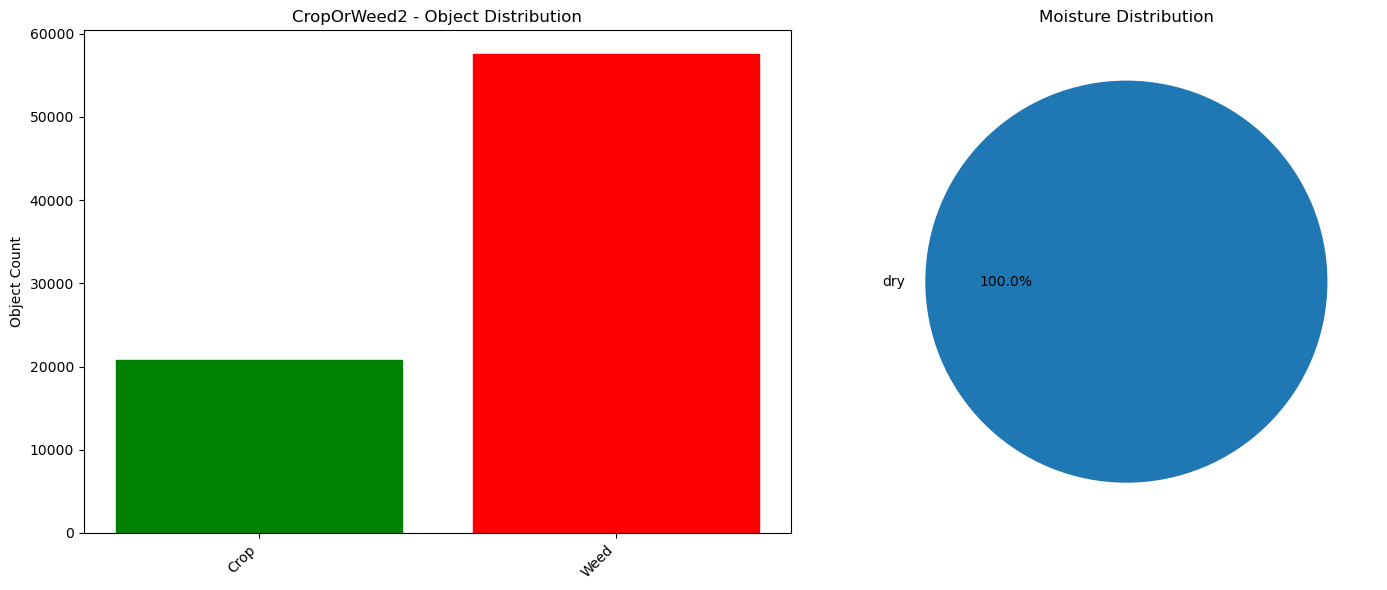

✓ Using CropOrWeed2 hierarchy (2 classes)
✓ Class distribution plot successful
✓ Using CropOrWeed2 hierarchy (2 classes)
✓ Enhanced generator created: 5 batches


2025-07-01 00:41:04.769423: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Max
2025-07-01 00:41:04.769460: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2025-07-01 00:41:04.769482: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2025-07-01 00:41:04.769528: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-07-01 00:41:04.769550: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


✗ Generator failed: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
✓ Using CropOrWeed2 hierarchy (2 classes)
✓ Classification generator created: 3 batches
✓ Classification batch: images (4, 224, 224, 3), labels (4, 2)

✓ Enhanced test complete!

2. Hierarchy comparison results:
  CropOrWeed2: 2 classes, 111953 objects
  CropsOrWeed9: 9 classes, 111953 objects
  Fine24: 24 classes, 111953 objects
  CropAndWeed: 101 classes, 111953 objects

3. Creating visualizations...
✓ Using CropOrWeed2 hierarchy (2 classes)


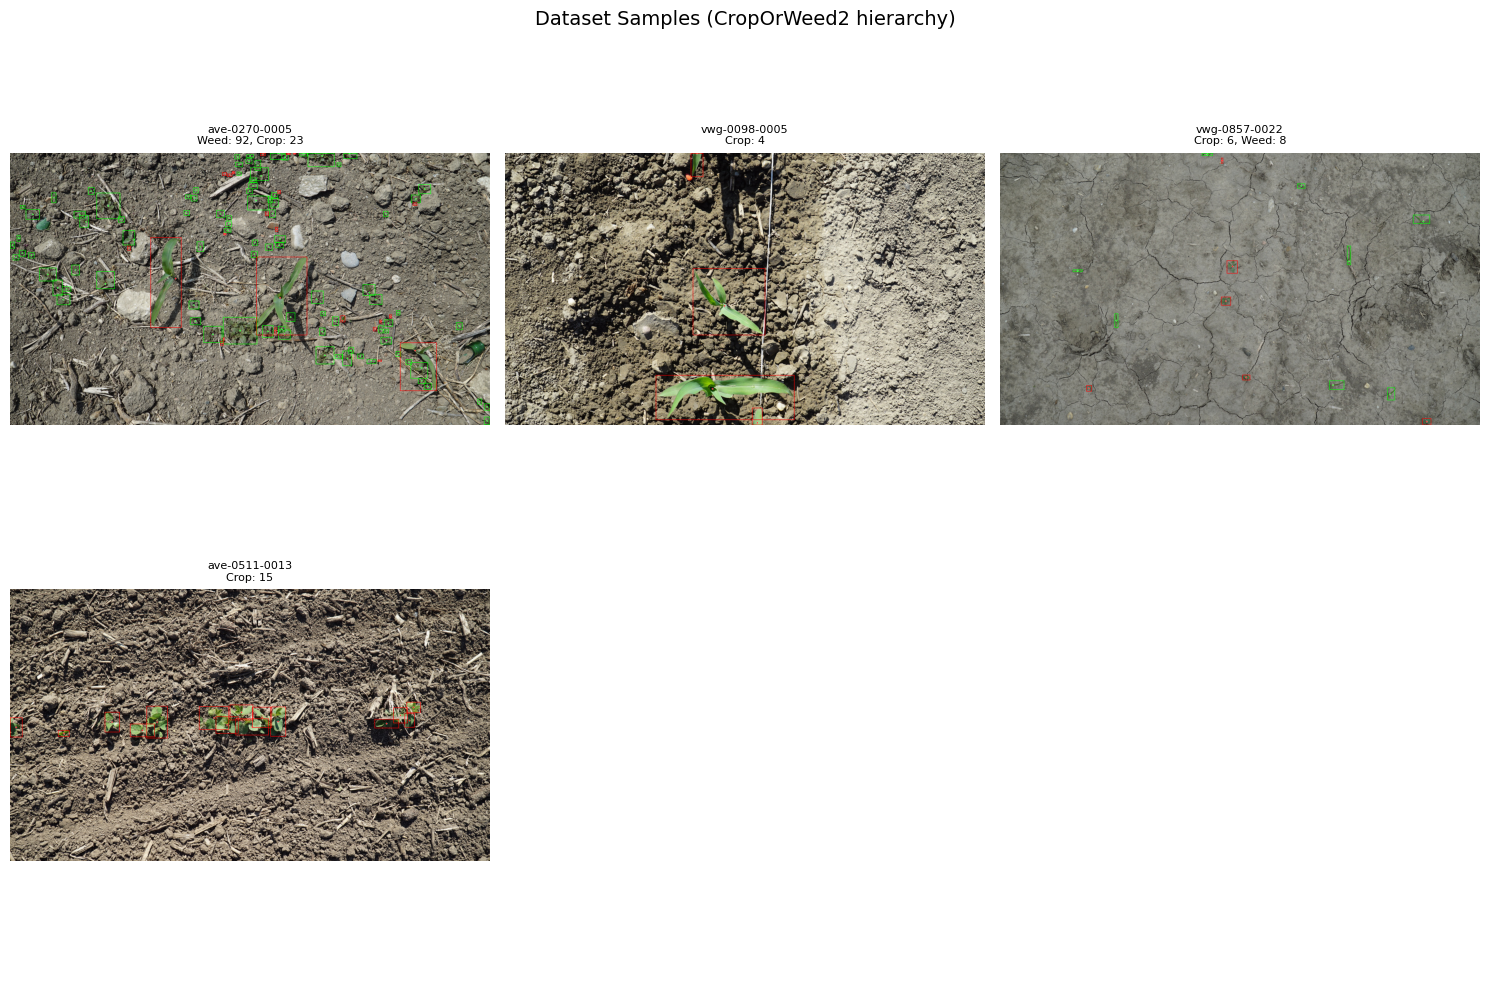


4. Creating models...
✓ Binary classifier: 4,415,781 parameters
✓ Segmentation model: 31,043,586 parameters
✓ Using CropsOrWeed9 hierarchy (9 classes)
✓ Multi-class model: 4,875,948 parameters

5. Progressive training schedule:
=== Progressive Training Schedule ===

Phase 1: Binary Classification:
  Hierarchy: CropOrWeed2
  Epochs: 15
  Image size: (224, 224)
  Batch size: 32
  Learning rate: 0.001
  Description: Learn basic crop vs weed distinction

Phase 2: Multi-crop Detection:
  Hierarchy: CropsOrWeed9
  Epochs: 25
  Image size: (256, 256)
  Batch size: 16
  Learning rate: 0.0001
  Description: Distinguish between different crop types

Phase 3: Fine-grained Recognition:
  Hierarchy: Fine24
  Epochs: 35
  Image size: (299, 299)
  Batch size: 8
  Learning rate: 1e-05
  Description: Fine-grained botanical family classification

6. Usage examples:

    CropAndWeed Dataset Pipeline - Usage Examples
    
    # 1. BASIC SETUP
    dataset_path = "/path/to/your/cropandweed/dataset"
    dat

In [11]:
if __name__ == "__main__":
    # Run main function when script is executed directly
    main()